## Equatorial Mount Pointing 

This is a simple tutorial on how to determine and correct (ot attempt to correct) the pointing offset of a telescope with equatorial mount.

In [1]:
offset_file = "examples/20130202.txt"

In [2]:
from IPython.display import Image

import numpy as np
from matplotlib import pylab as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from libs.io import read_file
from libs.Pfunctions import compute_M, compute_parameters


The "read_file" function extracts the coordinates for RA, DEC and the offset dRA, dDec, as well as the siderial time into numpy arrays. The function creates three arrays, a time corrected coordinate array, the offset and the angle $\phi$.

In [3]:
RADEC, RADEC2, phi = read_file(offset_file)
dRADEC = RADEC-RADEC2

In [4]:
print RADEC.shape, dRADEC.shape, phi.shape

(32, 2) (32, 2) (32,)


### ploting the offset vs. RA DEC

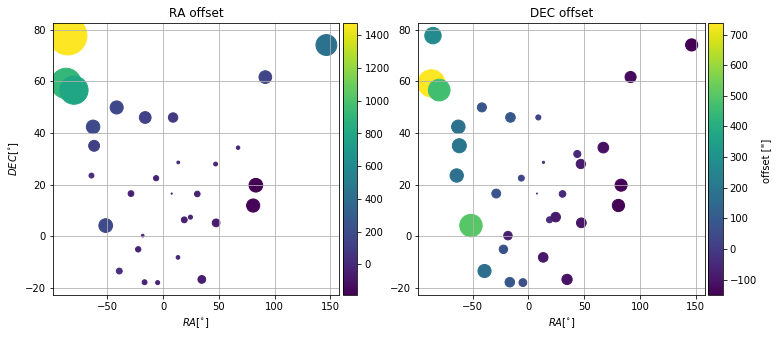

In [5]:
def plot_cart_offset(RADEC,dRADEC):
    fig = plt.figure(figsize=(12,5))
    ax1  = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.grid()
    ax2.grid()
    ax1.set_xlabel(r"$RA [^{\circ}]$")
    ax2.set_xlabel(r"$RA [^{\circ}]$")
    ax1.set_ylabel(r"$DEC [^{\circ}]$")
    ax1.set_title("RA offset")
    ax2.set_title("DEC offset")
    
    im1 = ax1.scatter(RADEC[:,0],RADEC[:,1],
                s = np.abs(dRADEC[:,0])*3600,
                marker='o', 
                c = (dRADEC[:,0])*3600)
    im2 = ax2.scatter(RADEC[:,0],RADEC[:,1],
                s = np.abs(dRADEC[:,1])*3600,
                marker='o', 
                c = (dRADEC[:,1])*3600)
    cax1  = make_axes_locatable(ax1).append_axes("right", size="5%", pad=0.05)
    cax2  = make_axes_locatable(ax2).append_axes("right", size="5%", pad=0.05)
    cbar  = plt.colorbar(im1, cax= cax1)
    cbar2 = plt.colorbar(im2, cax= cax2)
    cbar2.ax.set_ylabel('offset [\"] ', rotation=90)





    plt.show()
plot_cart_offset(RADEC,dRADEC)

## Computing the Coordinate dependent telescope offset using a set of Pointing Parameters (Offset Correction)

An recursive offset is determined by applying the following recursion:

$dC(dRA, dDEC) = \boldsymbol{M}(RA,DEC) \times \boldsymbol{P}$ 

The tensor dC represents the two vectors for the coordinate offset for a set of sources. The tensor is a convolution of $\boldsymbol{M}$ and the parameter tensor $\boldsymbol{P}$. In this case we want to compute the tensor dC from a set of coordinates given in a vector of RA and DEC as well as a set of  parameters given by $\boldsymbol{P}$. The construction diagram is given as follows:

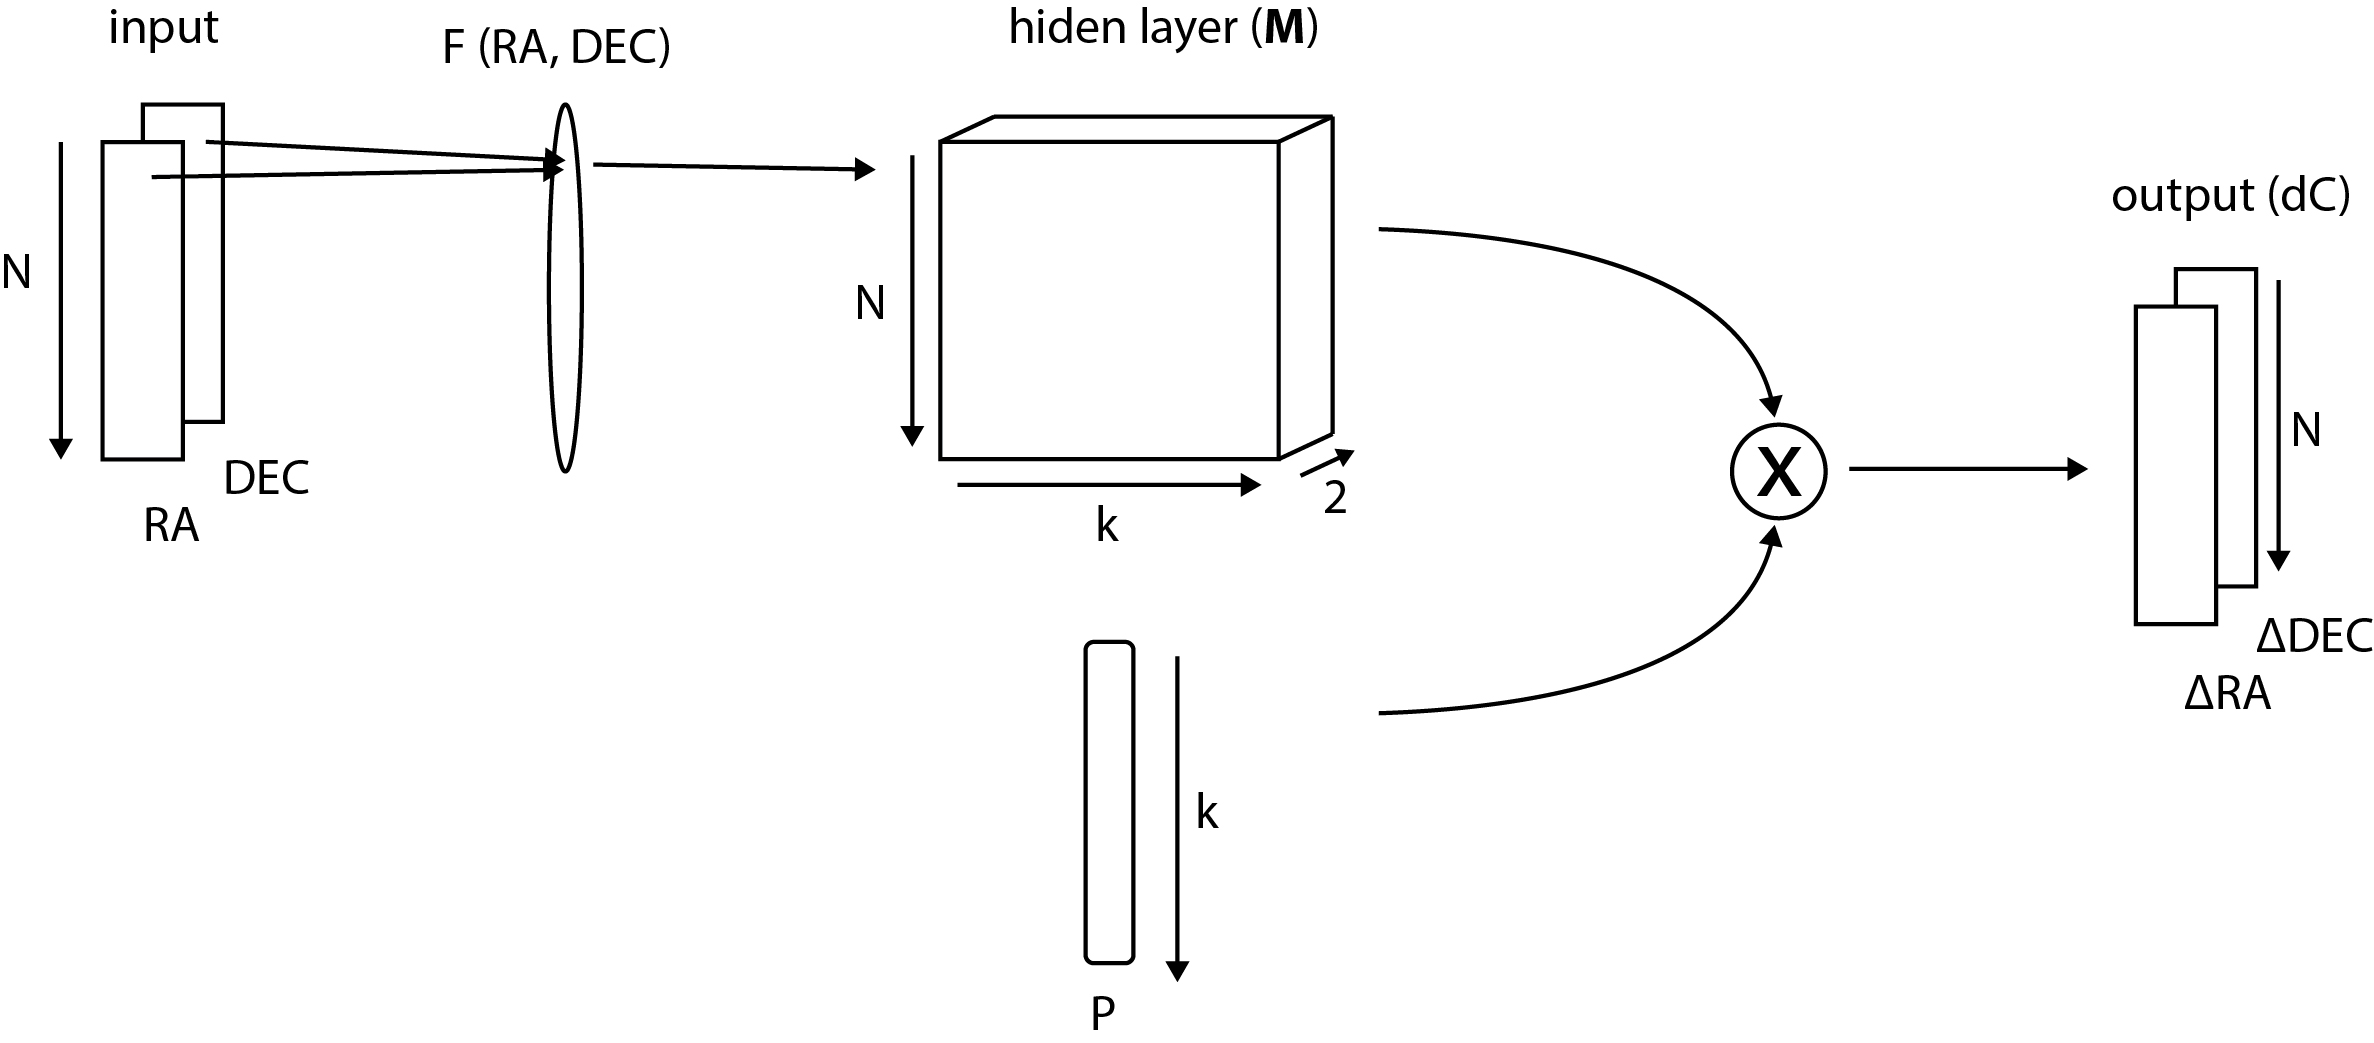

In [6]:
Image(filename=('pointNET.jpg'), width=600)

One can first compute the $\boldsymbol{M}$ by applying the function F to the input data cosisting of RA and DEC. In this case F is a set of trigonometric functions. This function is implimented in "compute_M".

In [7]:
M = compute_M(RADEC[:,0], RADEC[:,1],  phi)

In [8]:
print M.shape

(2, 32, 14)


Next we can load a set of parameters, which are provided in arcseconds.

In [9]:
PARAMETERS  = "p_parameters.txt"
P           = np.genfromtxt(PARAMETERS)
print PARAMETERS

p_parameters.txt


Now we can compute the relative offset (dC) to our given coordinates (RA, DEC) within $\boldsymbol{M}$ by convolving $\boldsymbol{M}$ and $\boldsymbol{P}$. 

In [10]:
dC = (-1.)*np.matmul(M,P).T/3600.

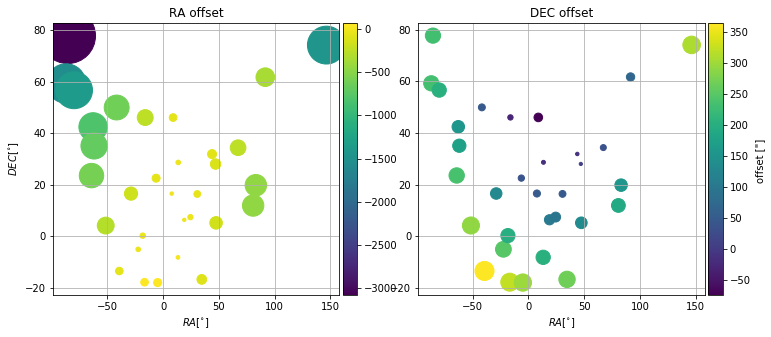

In [11]:
plot_cart_offset(RADEC,dC)

## Computing the pointing parameters $\boldsymbol{P}$

In an ideal case, where $\boldsymbol{M}$ is a square matrix (the number of parameters equals the number of coordinates and the offsets of RA and DEC are not convolved with each other), one could use a simple linear algebra solver (e.g. np.linalg.solver) to solve the two parts of $\boldsymbol{M}$ individually. However, for a large number of coordinates one can use backpropagation to approximate the parameters within $\boldsymbol{P}$. We can compute the Parameters as follows:

In [12]:
import torch
from torch.autograd import Variable

In [13]:
W = compute_parameters(M, dRADEC, learning_rate = 0.001, maxdW = 0.001)

One can varry the two arguments, learning rate and maxDW, where maxDW represents the the root presicion of the final parameters. This is basically a cutoff value for stopping the propagation process.

"compute_parameters" generates three arrays. We can obtain the parameters $\boldsymbol{P}$ in arcsecond from the last element of the first array as follows:

In [14]:
NP = W[0][-1]*3600.
print NP

[-426.40432739  412.3482666  -289.7166748   617.26153564 -232.03337097
 -224.29104614    1.67217946  -70.48931885 -352.5062561  -327.1086731
 -242.07017517   -7.50439072   -2.15685749  326.9352417 ]


The the arrays computed from compute_parameters represent the parameter $\boldsymbol{P}$, the differential Parameter $d\boldsymbol{P}$ and the Loss for each itteration. The following plot shows the development of the individual parameter for each itteration.

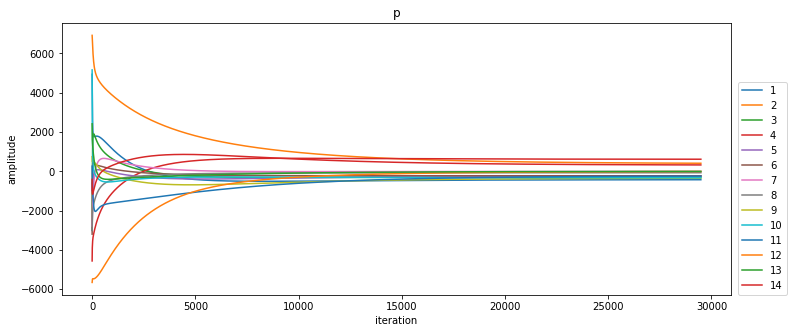

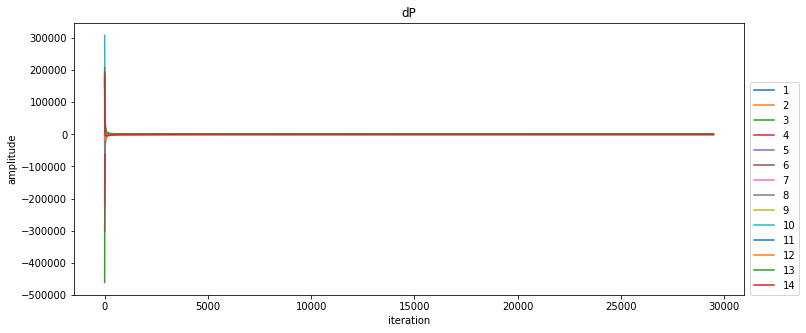

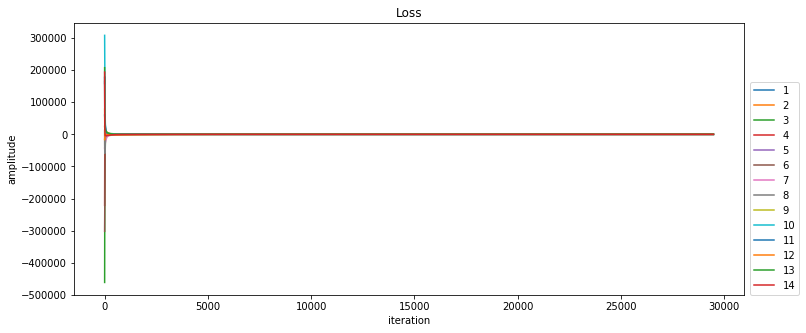

In [21]:
def plot_results(data, name = "p"):
    plt.figure(figsize = (12,5))
    for i in range(data.shape[1]):
        plt.plot(data[:,i]*3600., label = str(i+1))
    plt.legend(loc=(1.01,0))
    plt.xlabel("iteration")
    plt.ylabel("amplitude")
    plt.title(name)
    plt.show()
plot_results(W[0])
plot_results(W[1], "dP")
plot_results(W[1], "Loss")

Further, one could run "compute_parameters" multiple times to see if the parameters and their precision is stabel. But, lets assume we have used a sufficient amount of iterations and check whether the parameters we have computed, produce a sufficient correction. 

In [16]:
NP.shape

(14,)

In [17]:
NdC = np.matmul(M,NP).T/3600.

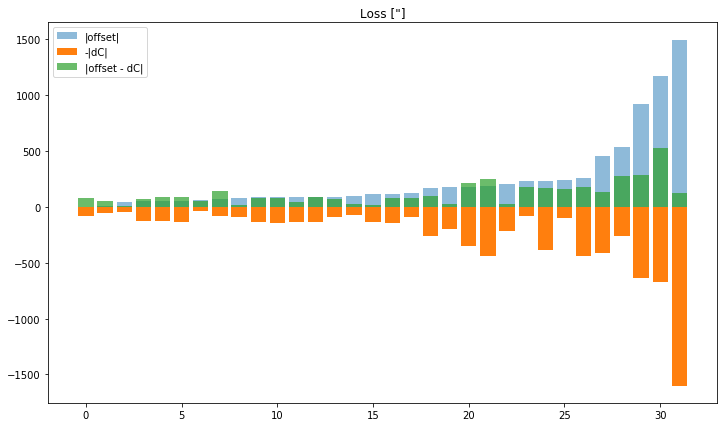

In [18]:
def amp(data):
    return np.sqrt(data[:,0]**2.+data[:,1]**2.)*3600.
ST = np.argsort(amp(dRADEC))
fig = plt.figure(figsize=(12,7))
plt.bar(range(dRADEC.shape[0]),amp(dRADEC)[ST]    ,label = "|offset|", alpha = 0.5)
plt.bar(range(dRADEC.shape[0]),-amp(NdC)[ST]      ,label = "-|dC|")
plt.bar(range(dRADEC.shape[0]),amp(dRADEC-NdC)[ST],label = "|offset - dC|", alpha = 0.7)
plt.legend()
plt.title("Loss [\"]")
plt.show()

offset


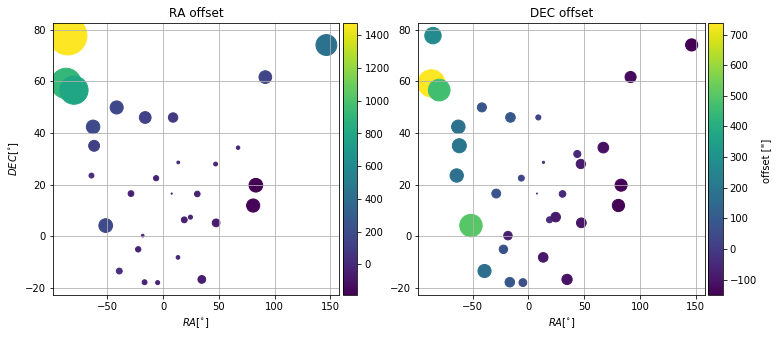

computed offset


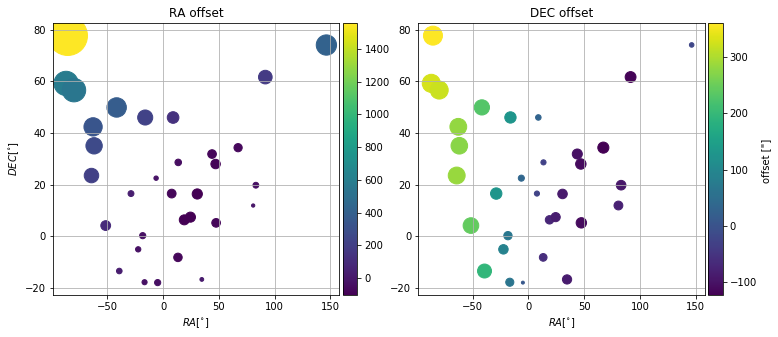

corrected offset


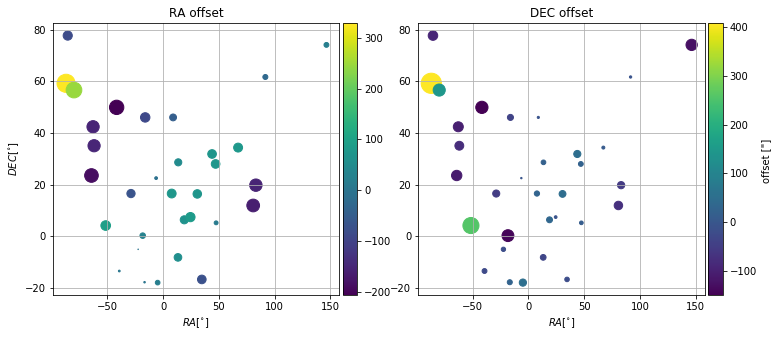

In [19]:
print "offset"
plot_cart_offset(RADEC,dRADEC)
print "computed offset"
plot_cart_offset(RADEC,NdC)
print "corrected offset"
plot_cart_offset(RADEC,dRADEC-NdC)